In [11]:
# ============================================================================
# IMPORTS AND SETUP
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Display settings for Jupyter
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)


In [12]:
# ============================================================================
# 1. LOAD AND PREVIEW DATA
# ============================================================================

def load_and_preview_data(filepath):
    """Load dataset and display initial overview"""
    print("="*80)
    print("1. DATA LOADING AND INITIAL PREVIEW")
    print("="*80)
    
    # Load data
    df = pd.read_csv(filepath)
    
    print(f"\nDataset Shape: {df.shape[0]} rows × {df.shape[1]} columns\n")
    
    print("First 5 rows:")
    print(df.head())
    
    print("\n\nLast 5 rows:")
    print(df.tail())
    
    print("\n\nColumn Names and Types:")
    print(df.dtypes)
    
    return df


In [13]:
# ============================================================================
# 2. SUMMARIZE FEATURES
# ============================================================================

def summarize_features(df):
    """Generate comprehensive summary statistics"""
    print("\n" + "="*80)
    print("2. FEATURE SUMMARY STATISTICS")
    print("="*80)
    
    # Numeric features
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    print(f"\nNumeric Features ({len(numeric_cols)}): {numeric_cols}")
    print("\nNumeric Summary Statistics:")
    print(df[numeric_cols].describe())
    
    # Categorical features
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    print(f"\n\nCategorical Features ({len(categorical_cols)}): {categorical_cols}")
    
    for col in categorical_cols:
        print(f"\n{col}:")
        print(f"  Unique values: {df[col].nunique()}")
        print(f"  Top 10 values:\n{df[col].value_counts().head(10)}")
    
    return numeric_cols, categorical_cols

In [14]:
# ============================================================================
# 3. DATA QUALITY CHECKS
# ============================================================================

def check_data_quality(df):
    """Check for missing values, duplicates, and inconsistencies"""
    print("\n" + "="*80)
    print("3. DATA QUALITY CHECKS")
    print("="*80)
    
    # Missing values
    print("\nMissing Values:")
    missing = df.isnull().sum()
    missing_pct = 100 * missing / len(df)
    missing_df = pd.DataFrame({
        'Missing_Count': missing,
        'Missing_Percentage': missing_pct
    }).sort_values('Missing_Count', ascending=False)
    print(missing_df[missing_df['Missing_Count'] > 0])
    
    if missing_df['Missing_Count'].sum() == 0:
        print("✓ No missing values found!")
    
    # Duplicates
    print("\n\nDuplicate Rows:")
    duplicates = df.duplicated().sum()
    print(f"Total duplicate rows: {duplicates}")
    if duplicates > 0:
        print(f"⚠ Warning: {duplicates} duplicate rows detected!")
    else:
        print("✓ No duplicate rows found!")
    
    # Check for zero or negative salaries
    print("\n\nSalary Anomalies:")
    zero_salary = (df['salary'] == 0).sum()
    negative_salary = (df['salary'] < 0).sum()
    zero_usd = (df['salary_in_usd'] == 0).sum()
    negative_usd = (df['salary_in_usd'] < 0).sum()
    
    print(f"Zero salaries: {zero_salary}")
    print(f"Negative salaries: {negative_salary}")
    print(f"Zero USD salaries: {zero_usd}")
    print(f"Negative USD salaries: {negative_usd}")
    
    return missing_df


In [15]:
# ============================================================================
# 4. OUTLIER DETECTION
# ============================================================================

def detect_outliers(df, numeric_cols):
    """Detect outliers using IQR method and visualizations"""
    print("\n" + "="*80)
    print("4. OUTLIER DETECTION")
    print("="*80)
    
    outlier_summary = {}
    
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_count = len(outliers)
        outlier_pct = 100 * outlier_count / len(df)
        
        outlier_summary[col] = {
            'Count': outlier_count,
            'Percentage': outlier_pct,
            'Lower_Bound': lower_bound,
            'Upper_Bound': upper_bound
        }
    
    outlier_df = pd.DataFrame(outlier_summary).T
    print("\nOutlier Summary (IQR Method):")
    print(outlier_df)
    
    # Visualize outliers
    fig, axes = plt.subplots(len(numeric_cols), 1, figsize=(12, 4*len(numeric_cols)))
    if len(numeric_cols) == 1:
        axes = [axes]
    
    for i, col in enumerate(numeric_cols):
        axes[i].boxplot(df[col].dropna(), vert=False)
        axes[i].set_xlabel(col)
        axes[i].set_title(f'Boxplot: {col}')
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('outlier_boxplots.png', dpi=300, bbox_inches='tight')
    plt.show()  # Display in Jupyter
    print("\n✓ Boxplots saved as 'outlier_boxplots.png'")
    
    return outlier_df

In [16]:
# ============================================================================
# 5. DISTRIBUTION VISUALIZATIONS
# ============================================================================

def visualize_distributions(df, numeric_cols, categorical_cols):
    """Create histograms and bar plots for all features"""
    print("\n" + "="*80)
    print("5. DISTRIBUTION VISUALIZATIONS")
    print("="*80)
    
    # Numeric distributions
    fig, axes = plt.subplots(len(numeric_cols), 2, figsize=(15, 5*len(numeric_cols)))
    if len(numeric_cols) == 1:
        axes = axes.reshape(1, -1)
    
    for i, col in enumerate(numeric_cols):
        # Histogram
        axes[i, 0].hist(df[col].dropna(), bins=50, edgecolor='black', alpha=0.7)
        axes[i, 0].set_xlabel(col)
        axes[i, 0].set_ylabel('Frequency')
        axes[i, 0].set_title(f'Histogram: {col}')
        axes[i, 0].grid(True, alpha=0.3)
        
        # Boxplot
        axes[i, 1].boxplot(df[col].dropna(), vert=False)
        axes[i, 1].set_xlabel(col)
        axes[i, 1].set_title(f'Boxplot: {col}')
        axes[i, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('numeric_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()  # Display in Jupyter
    print("\n✓ Numeric distributions saved as 'numeric_distributions.png'")
    
    # Categorical distributions (top categories only)
    for col in categorical_cols:
        plt.figure(figsize=(12, 6))
        top_categories = df[col].value_counts().head(20)
        top_categories.plot(kind='barh')
        plt.xlabel('Count')
        plt.title(f'Top 20 Categories: {col}')
        plt.tight_layout()
        plt.savefig(f'categorical_{col}.png', dpi=300, bbox_inches='tight')
        plt.show()  # Display in Jupyter
        print(f"✓ Bar plot for '{col}' saved as 'categorical_{col}.png'")

In [17]:
# ============================================================================
# 6. CORRELATION ANALYSIS
# ============================================================================

def analyze_correlations(df, numeric_cols, categorical_cols):
    """Compute correlations and cross-tabulations"""
    print("\n" + "="*80)
    print("6. CORRELATION ANALYSIS")
    print("="*80)
    
    # Numeric correlations
    print("\nNumeric Feature Correlations:")
    corr_matrix = df[numeric_cols].corr()
    print(corr_matrix)
    
    # Correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Correlation Heatmap - Numeric Features')
    plt.tight_layout()
    plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()  # Display in Jupyter
    print("\n✓ Correlation heatmap saved as 'correlation_heatmap.png'")
    
    # Categorical vs Numeric (example: salary by experience level)
    print("\n\nCross-tabulation Examples:")
    print("\nMean Salary (USD) by Experience Level:")
    print(df.groupby('experience_level')['salary_in_usd'].agg(['mean', 'median', 'count']))
    
    print("\nMean Salary (USD) by Company Size:")
    print(df.groupby('company_size')['salary_in_usd'].agg(['mean', 'median', 'count']))
    
    print("\nMean Salary (USD) by Remote Ratio:")
    print(df.groupby('remote_ratio')['salary_in_usd'].agg(['mean', 'median', 'count']))
    
    return corr_matrix

In [18]:
# ============================================================================
# 7. DATA QUALITY ISSUES
# ============================================================================

def identify_quality_issues(df, categorical_cols):
    """Identify potential data quality issues"""
    print("\n" + "="*80)
    print("7. DATA QUALITY ISSUES")
    print("="*80)
    
    issues = []
    
    # Check for inconsistent categories (case sensitivity, whitespace)
    print("\nChecking for inconsistent categorical values...")
    for col in categorical_cols:
        unique_vals = df[col].unique()
        # Check for potential duplicates with different cases
        lower_vals = [str(v).lower().strip() for v in unique_vals if pd.notna(v)]
        if len(lower_vals) != len(set(lower_vals)):
            issues.append(f"⚠ '{col}' may have case-sensitive duplicates")
            print(f"  ⚠ {col}: Potential case-sensitivity issues")
    
    # Check for extreme values in salary
    print("\nChecking for extreme salary values...")
    salary_mean = df['salary_in_usd'].mean()
    salary_std = df['salary_in_usd'].std()
    extreme_threshold = salary_mean + 4 * salary_std
    
    extreme_salaries = df[df['salary_in_usd'] > extreme_threshold]
    if len(extreme_salaries) > 0:
        issues.append(f"⚠ {len(extreme_salaries)} extremely high salaries (>4 std devs)")
        print(f"  ⚠ Found {len(extreme_salaries)} extremely high salaries")
        print(f"    Top 5 highest: {df['salary_in_usd'].nlargest(5).values}")
    
    # Check for class imbalance
    print("\nChecking for class imbalance...")
    for col in categorical_cols:
        value_counts = df[col].value_counts()
        max_count = value_counts.max()
        min_count = value_counts.min()
        imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')
        
        if imbalance_ratio > 100:
            issues.append(f"⚠ '{col}' is highly imbalanced (ratio: {imbalance_ratio:.1f}:1)")
            print(f"  ⚠ {col}: Imbalance ratio {imbalance_ratio:.1f}:1")
            print(f"    Most common: {value_counts.index[0]} ({value_counts.iloc[0]} samples)")
            print(f"    Least common: {value_counts.index[-1]} ({value_counts.iloc[-1]} samples)")
    
    if len(issues) == 0:
        print("\n✓ No major data quality issues detected!")
    else:
        print(f"\n⚠ Total issues found: {len(issues)}")
    
    return issues

In [19]:
# ============================================================================
# 8. COMPREHENSIVE SUMMARY TABLE
# ============================================================================

def create_summary_table(df, missing_df):
    """Create comprehensive feature summary table"""
    print("\n" + "="*80)
    print("8. COMPREHENSIVE FEATURE SUMMARY")
    print("="*80)
    
    summary_data = []
    
    for col in df.columns:
        row = {
            'Feature': col,
            'Type': str(df[col].dtype),
            'Missing_Count': missing_df.loc[col, 'Missing_Count'] if col in missing_df.index else 0,
            'Missing_Pct': f"{missing_df.loc[col, 'Missing_Percentage']:.2f}%" if col in missing_df.index else "0.00%",
            'Unique_Values': df[col].nunique(),
            'Most_Common': df[col].mode()[0] if len(df[col].mode()) > 0 else None,
        }
        
        if df[col].dtype in [np.int64, np.float64]:
            row['Min'] = df[col].min()
            row['Max'] = df[col].max()
            row['Mean'] = df[col].mean()
            row['Median'] = df[col].median()
        else:
            row['Min'] = None
            row['Max'] = None
            row['Mean'] = None
            row['Median'] = None
        
        summary_data.append(row)
    
    summary_df = pd.DataFrame(summary_data)
    print("\nFeature Summary Table:")
    print(summary_df.to_string(index=False))
    
    # Save to CSV
    summary_df.to_csv('feature_summary_table.csv', index=False)
    print("\n✓ Summary table saved as 'feature_summary_table.csv'")
    
    return summary_df



COMPREHENSIVE DATA EXPLORATION REPORT
1. DATA LOADING AND INITIAL PREVIEW

Dataset Shape: 4644 rows × 11 columns

First 5 rows:
   work_year experience_level employment_type  \
0       2020               EX              FT   
1       2020               MI              FT   
2       2020               MI              FT   
3       2020               MI              FT   
4       2020               SE              FT   

                                  job_title  salary salary_currency  \
0                            Data Scientist  300000             USD   
1  Machine Learning Infrastructure Engineer   44000             EUR   
2                         Lead Data Analyst   87000             USD   
3                             Data Engineer   88000             GBP   
4                       Lead Data Scientist  190000             USD   

   salary_in_usd employee_residence  remote_ratio company_location  \
0         300000                 US           100               US   
1        

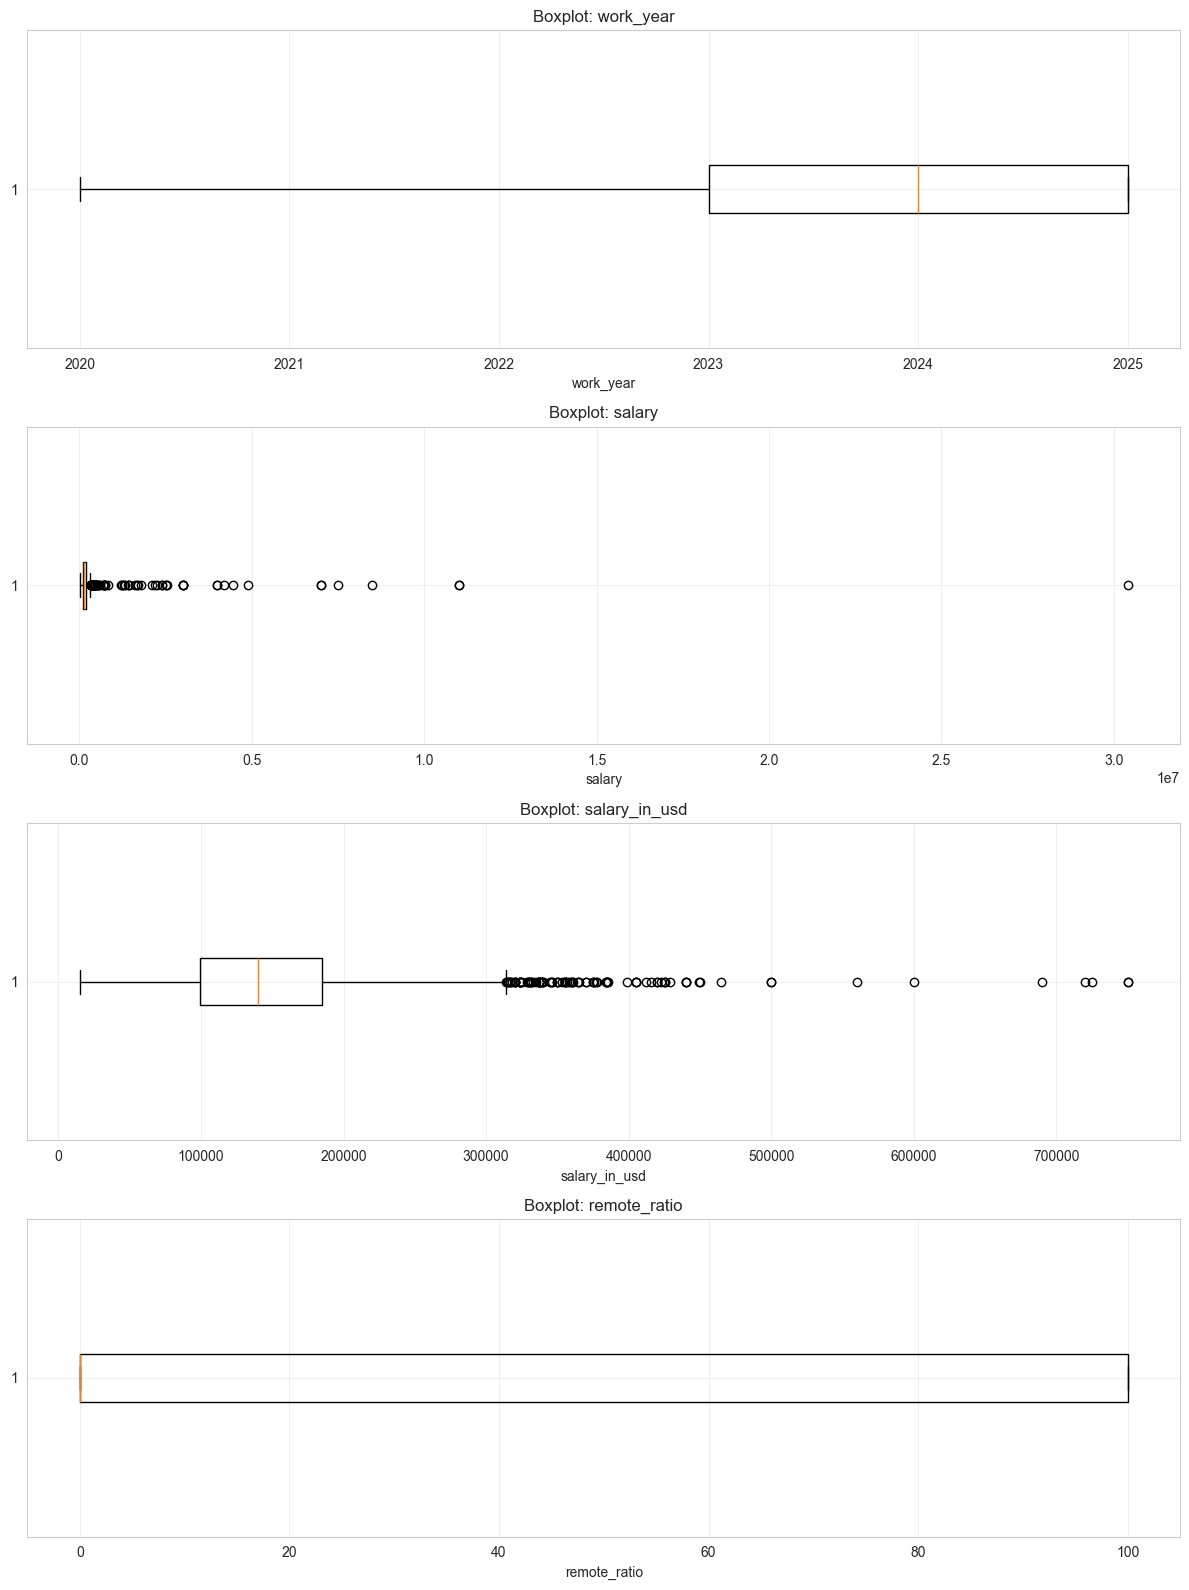


✓ Boxplots saved as 'outlier_boxplots.png'

5. DISTRIBUTION VISUALIZATIONS


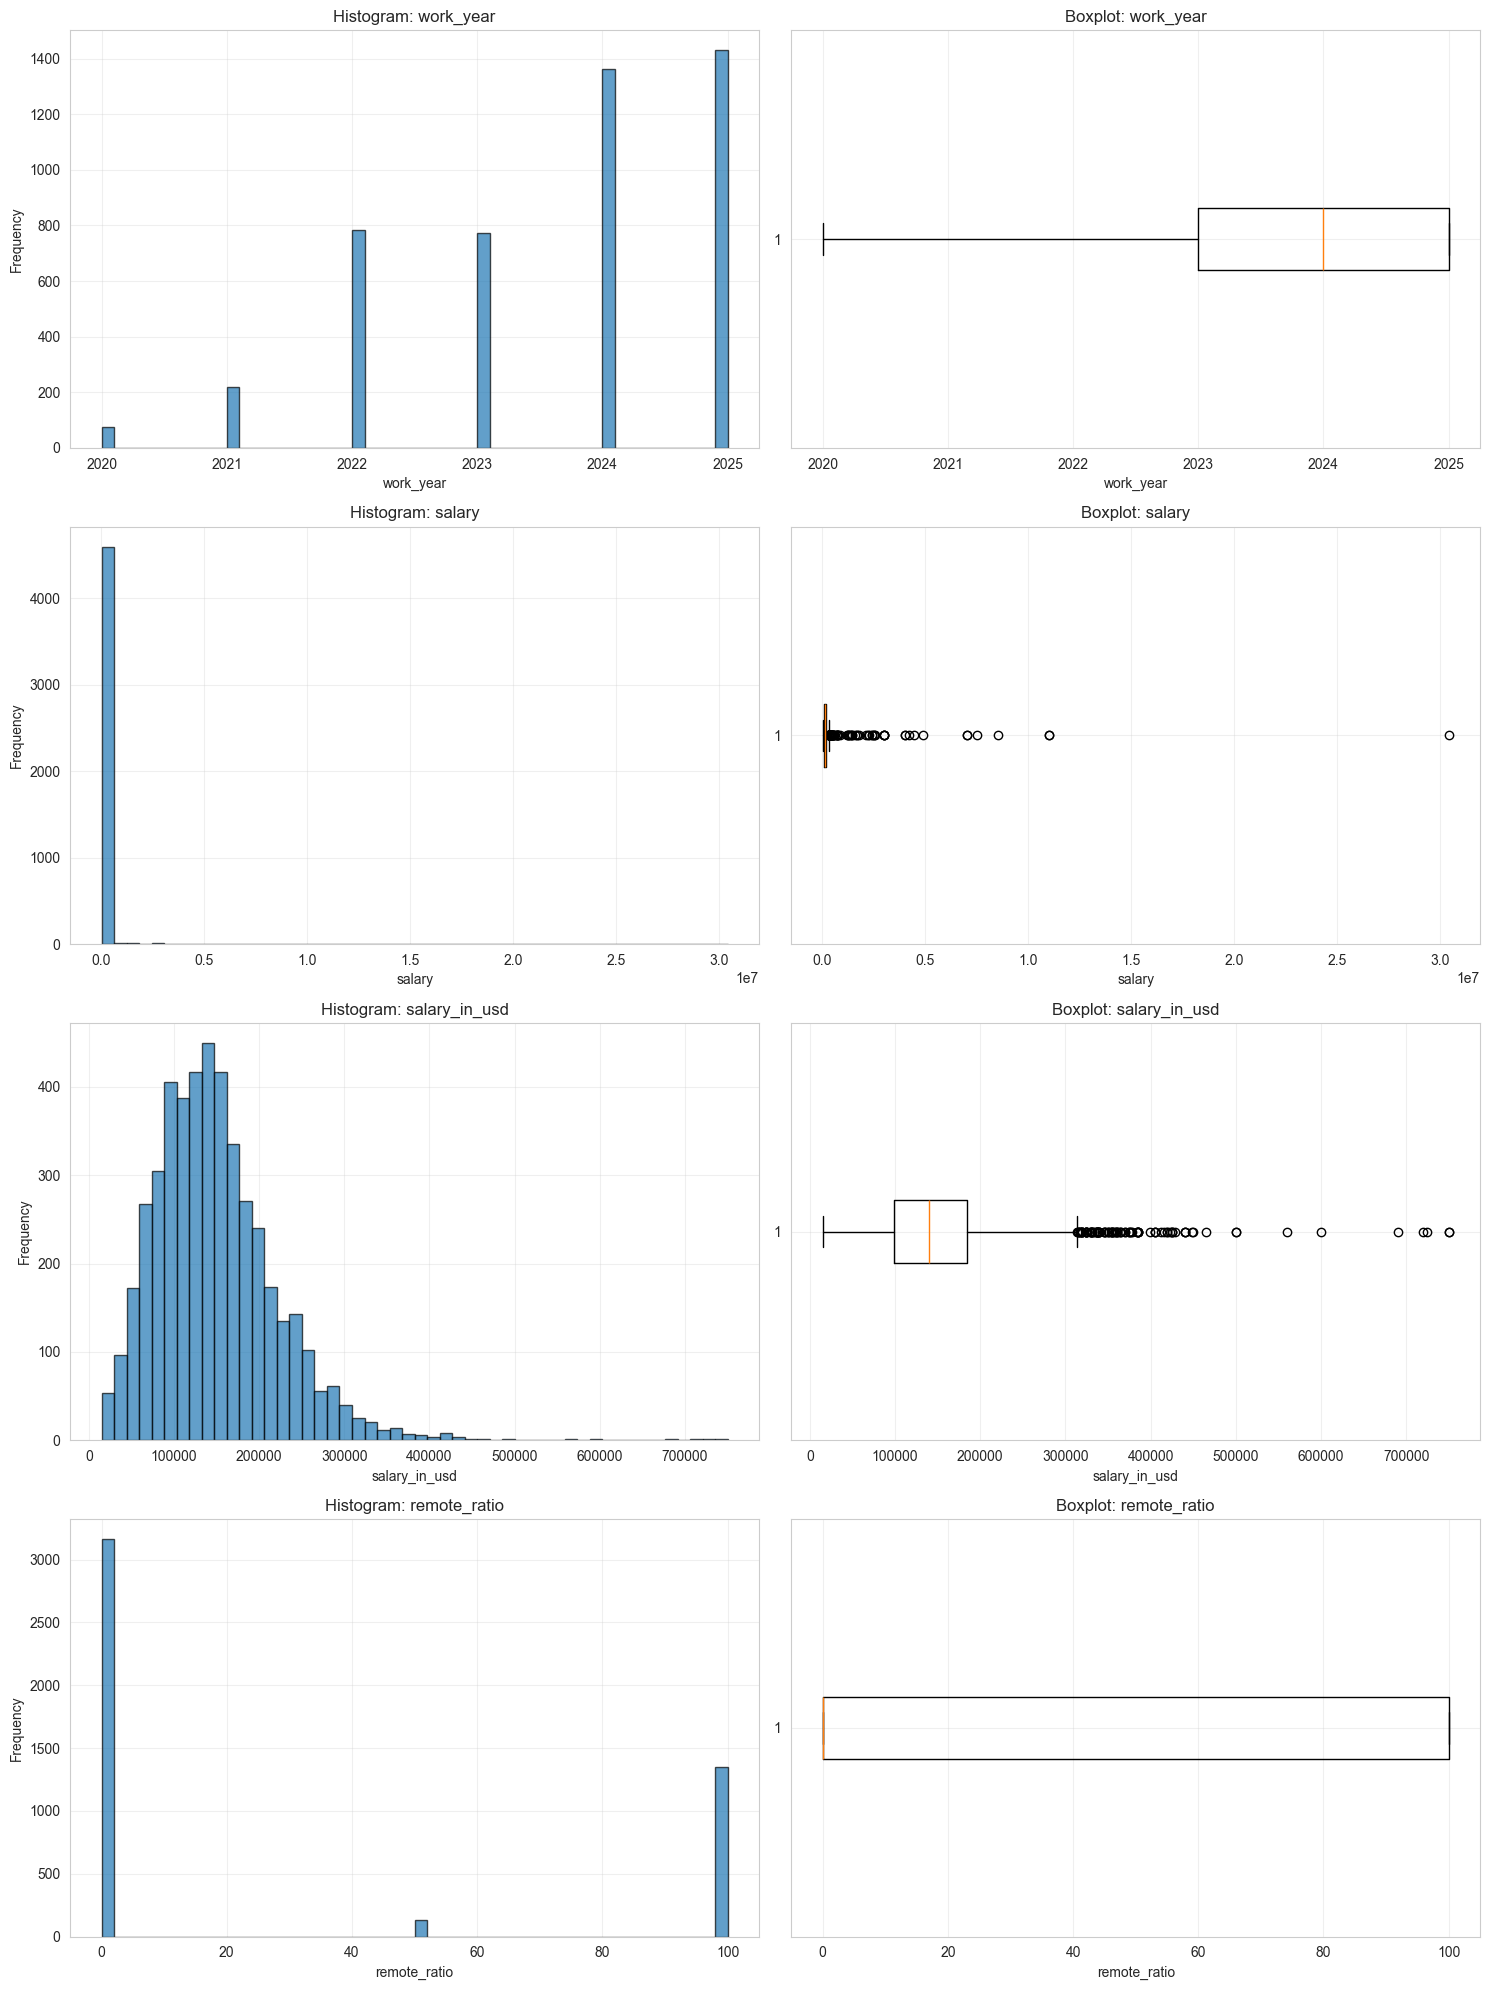


✓ Numeric distributions saved as 'numeric_distributions.png'


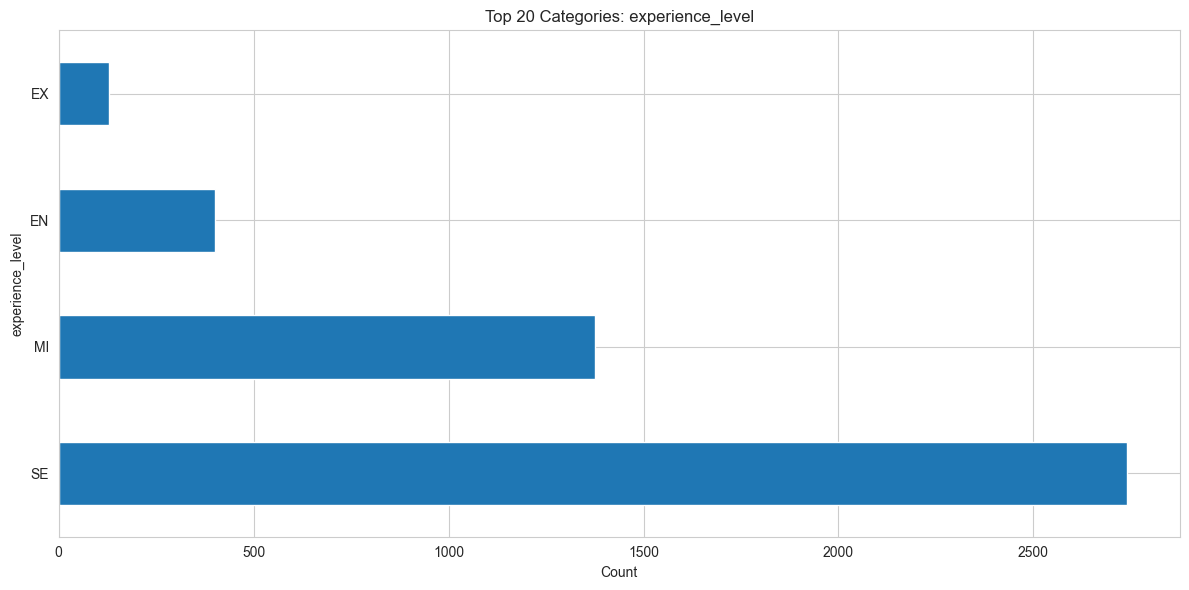

✓ Bar plot for 'experience_level' saved as 'categorical_experience_level.png'


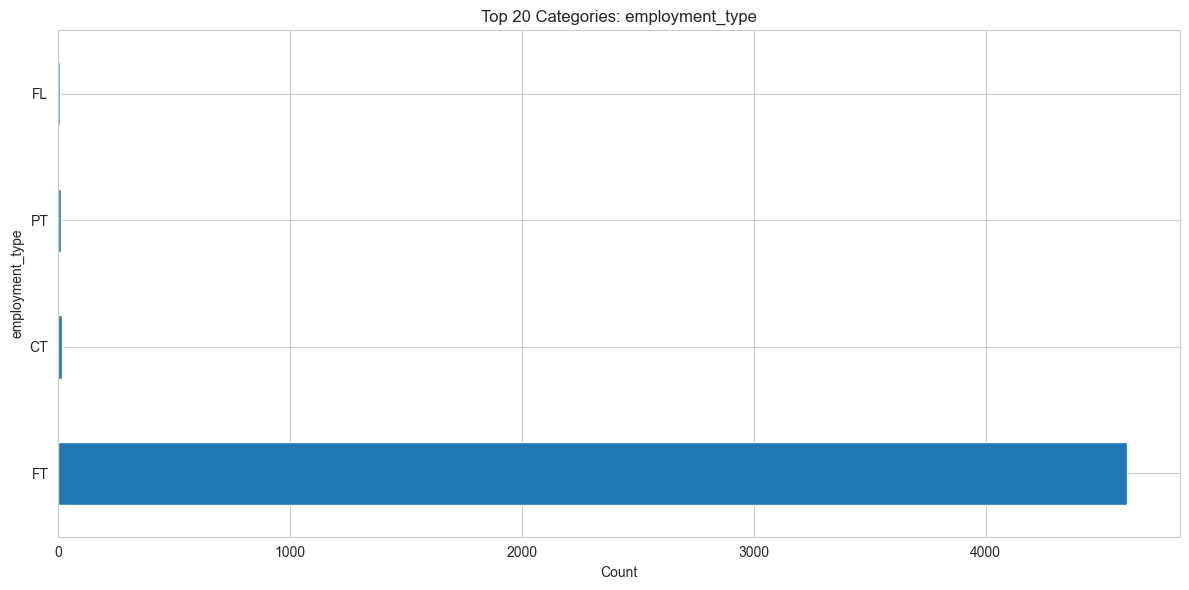

✓ Bar plot for 'employment_type' saved as 'categorical_employment_type.png'


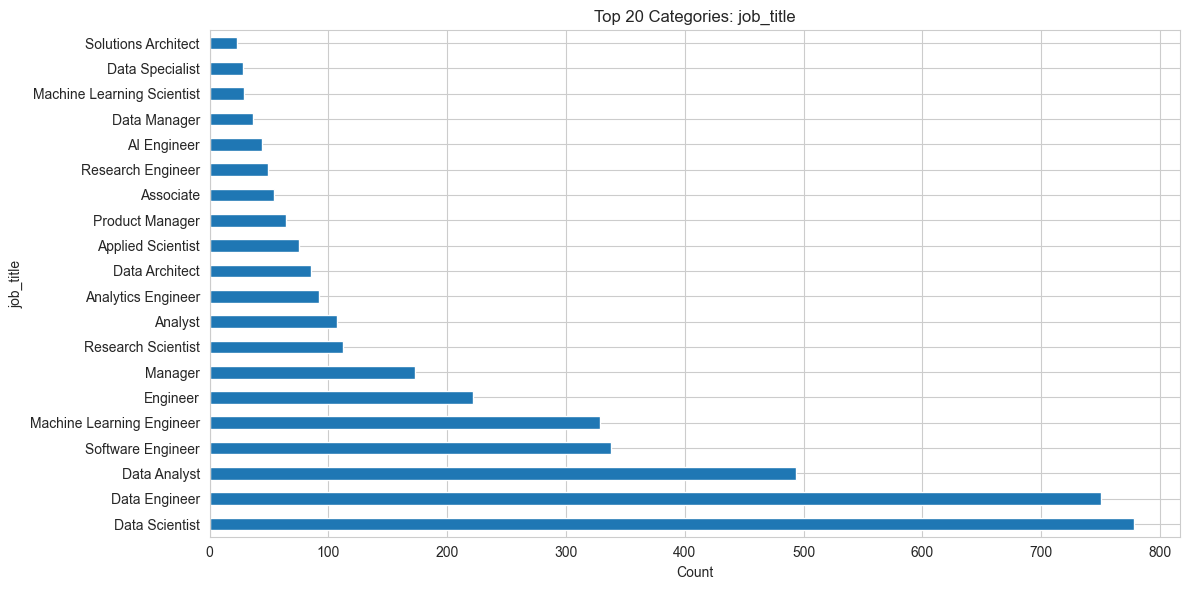

✓ Bar plot for 'job_title' saved as 'categorical_job_title.png'


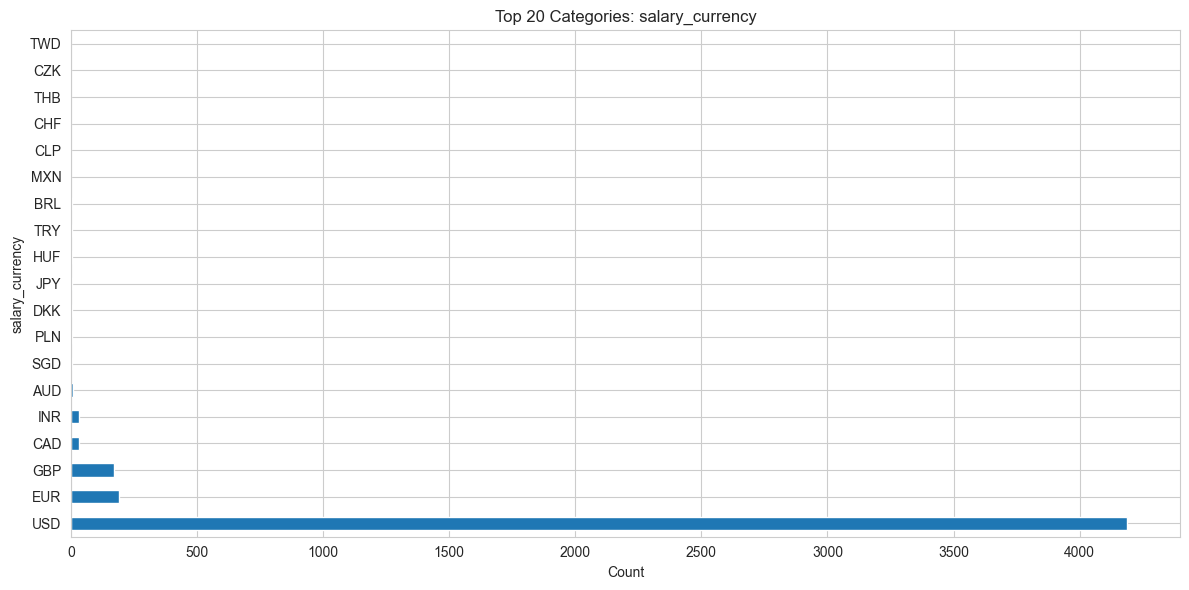

✓ Bar plot for 'salary_currency' saved as 'categorical_salary_currency.png'


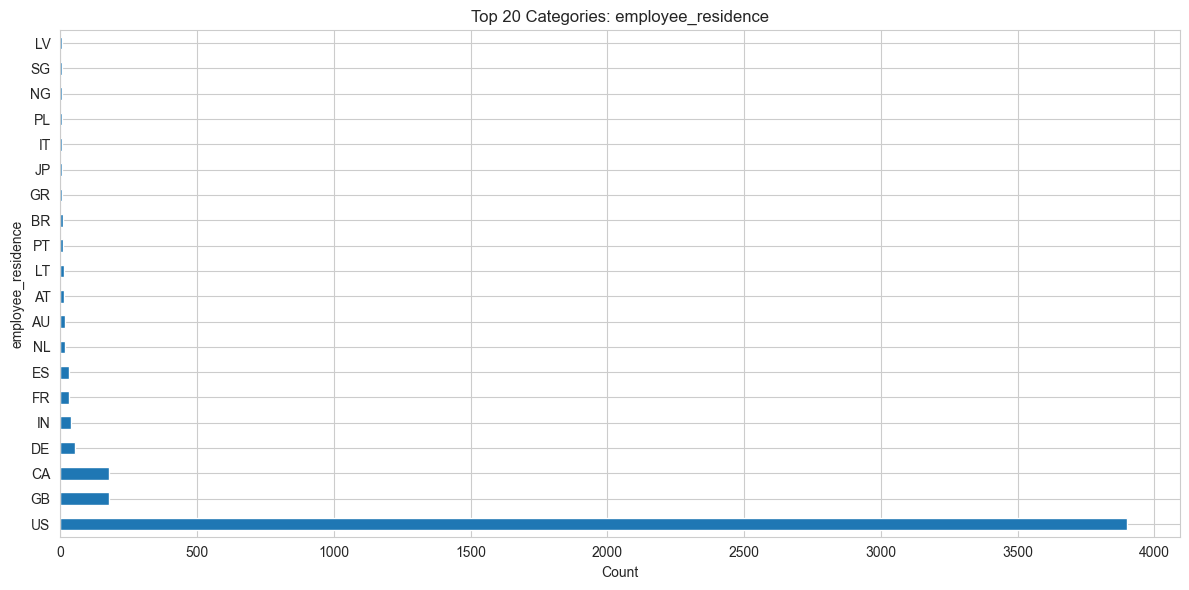

✓ Bar plot for 'employee_residence' saved as 'categorical_employee_residence.png'


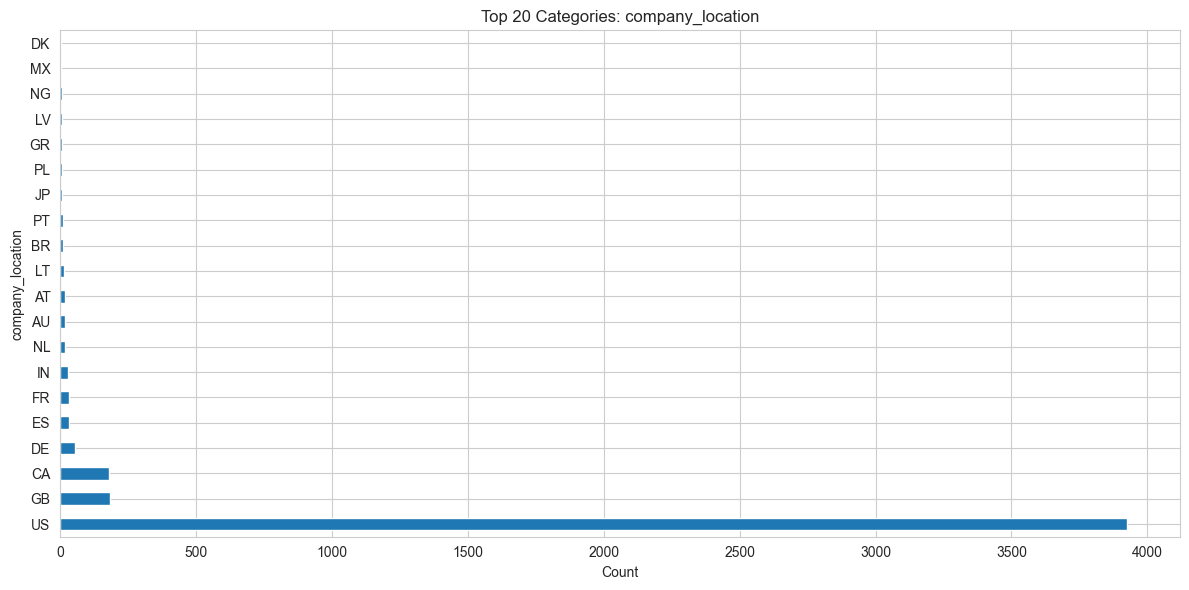

✓ Bar plot for 'company_location' saved as 'categorical_company_location.png'


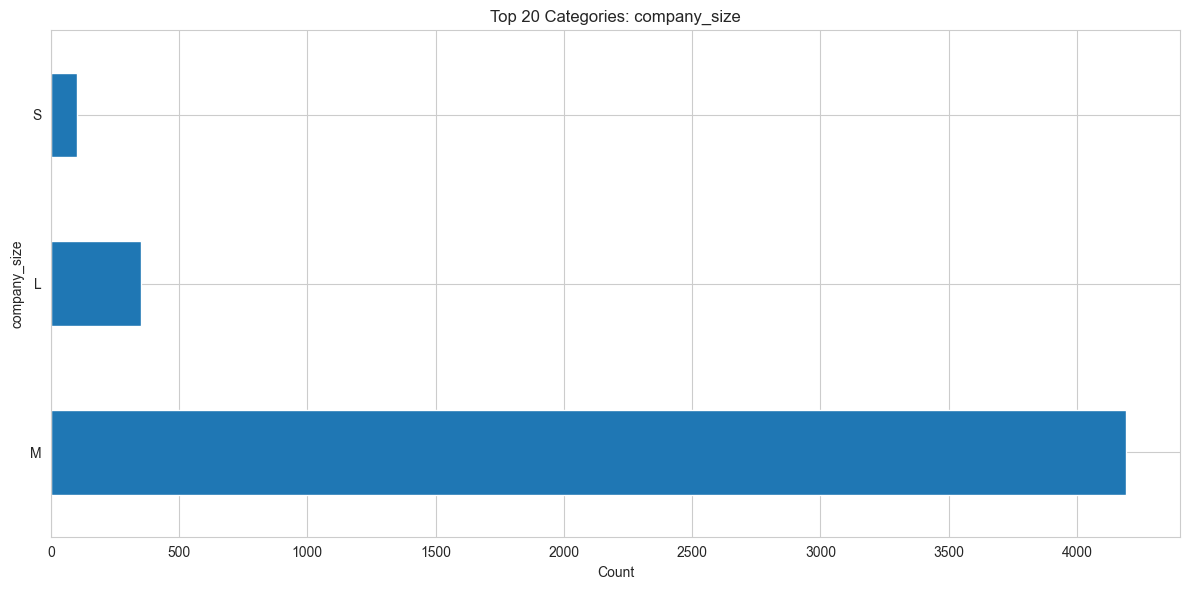

✓ Bar plot for 'company_size' saved as 'categorical_company_size.png'

6. CORRELATION ANALYSIS

Numeric Feature Correlations:
               work_year    salary  salary_in_usd  remote_ratio
work_year       1.000000 -0.083510       0.170278     -0.328611
salary         -0.083510  1.000000       0.042560      0.035646
salary_in_usd   0.170278  0.042560       1.000000     -0.077736
remote_ratio   -0.328611  0.035646      -0.077736      1.000000


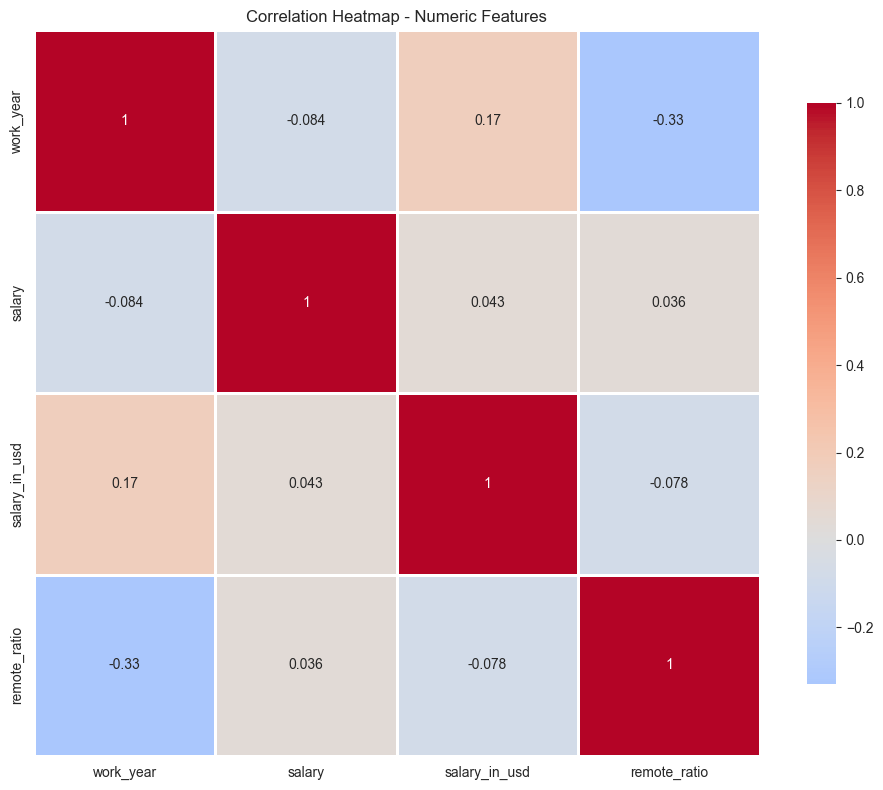


✓ Correlation heatmap saved as 'correlation_heatmap.png'


Cross-tabulation Examples:

Mean Salary (USD) by Experience Level:
                           mean    median  count
experience_level                                
EN                 87379.182500   80000.0    400
EX                208049.162791  200000.0    129
MI                128411.554506  118000.0   1376
SE                164388.748083  154600.0   2739

Mean Salary (USD) by Company Size:
                       mean    median  count
company_size                                
L             127524.920455  119650.0    352
M             151523.166269  142183.0   4192
S              86712.100000   74824.0    100

Mean Salary (USD) by Remote Ratio:
                       mean    median  count
remote_ratio                                
0             153327.955120  142200.0   3164
50             85932.293233   69133.0    133
100           142677.394209  140000.0   1347

7. DATA QUALITY ISSUES

Checking for inconsistent catego

In [20]:
# ============================================================================
# 9. MAIN EXECUTION FOR JUPYTER NOTEBOOK
# ============================================================================

# Load the dataset
filepath = 'FoAI_A2_data_4.6k.csv'  
df = pd.read_csv(filepath)

print("\n" + "="*80)
print("COMPREHENSIVE DATA EXPLORATION REPORT")
print("="*80)

# Execute all analysis steps
# 1. Load and preview data
df_loaded = load_and_preview_data(filepath)

# 2. Summarize features
numeric_cols, categorical_cols = summarize_features(df_loaded)

# 3. Data quality checks
missing_df = check_data_quality(df_loaded)

# 4. Outlier detection
outlier_df = detect_outliers(df_loaded, numeric_cols)

# 5. Visualize distributions
visualize_distributions(df_loaded, numeric_cols, categorical_cols)

# 6. Correlation analysis
corr_matrix = analyze_correlations(df_loaded, numeric_cols, categorical_cols)

# 7. Identify quality issues
issues = identify_quality_issues(df_loaded, categorical_cols)

# 8. Create summary table
summary_df = create_summary_table(df_loaded, missing_df)

print("\n" + "="*80)
print("EXPLORATION COMPLETE")
print("="*80)
print("\nGenerated Files:")
print("  • outlier_boxplots.png")
print("  • numeric_distributions.png")
print("  • categorical_[feature].png (for each categorical feature)")
print("  • correlation_heatmap.png")
print("  • feature_summary_table.csv")
print("\n✓ All visualizations displayed inline in Jupyter Notebook")